In [6]:
import pde_nn.channel_flow as chan
import matplotlib.pyplot as plt
import numpy as np
import utils

In [16]:
# overall hypers
pde_nn = chan.Chanflow()
hypers=pde_nn.hypers
retau=utils.calc_retau(hypers['delta'], hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Calculating at Retau={}'.format(retau))

# grid
delta=hypers['delta']
n = 1000
y = np.linspace(hypers['ymin'], hypers['ymax'], n)
delta_y = y[1] - y[0]
u0 = np.ones_like(y)
U_0, U_L = 0, 0

Calculating at Retau=180.0000018


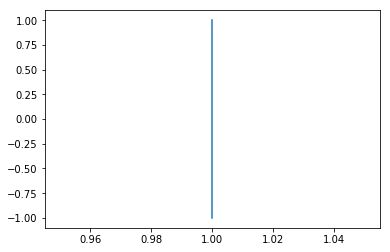

In [11]:
plt.plot(u0, y)

In [8]:
# just here for reference.
# reynolds_stress_fn = lambda y, du_dy: -1*((hypers['k']*(np.abs(y)-delta))**2)*np.abs(du_dy)*du_dy
# diffeq = lambda du2_dy2, dre_dy: hypers['nu']*du2_dy2 - dre_dy - (1/hypers['rho']) * hypers['dp_dx']

In [12]:
def handle_boundary(u, i, n):
    # careful with boundaries. contains {i-2, i-1, i, i+1, i+2}
    # if we step on or beyond the boundary, just set to the boundary (check this assumption!)
    # returns u[i-2], u[i-1], u[i], u[i+1], u[i+2] while respecting boundary conditions

    if i==0: # far left
        return U_0, U_0, u[i], u[i+1], u[i+2]
    elif i==1: # second from left
        return U_0, u[i-1], u[i], u[i+1], u[i+2]
    elif i==n-2: # second from right
        return u[i-2], u[i-1], u[i], u[i+1], U_L
    elif i==n-1: # far right
        return u[i-2], u[i-1], u[i], U_L, U_L
    else: # no boundaries
        return u[i-2], u[i-1], u[i], u[i+1], u[i+2]

def Gf(u):
    n = u.shape[0]
    gvec = np.zeros(n)
    for i in range(n):
        
        uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
        yim1, yip1 = y[i] - delta_y, y[i] + delta_y
            
        a = (hypers['nu'] / (delta_y ** 2)) * (uip1 - 2*ui + uim1) 
        fplus = (uip2 - ui) / (2*delta_y)
        fminus = (ui - uim2) / (2*delta_y)
        b = (1 / (2 * delta_y)) * ((hypers['k'] * np.abs(yip1 - delta)) ** 2) * np.abs(fplus) * fplus 
        c = (-1 / (2 * delta_y)) * ((hypers['k'] * np.abs(yim1 - delta)) ** 2) * np.abs(fminus) * fminus
        d = (-1 / hypers['rho']) * hypers['dp_dx']
        
        gvec[i] = a + b + c + d
        
    return gvec

def dGi_ui(u, i, eps=1e-8):
    n = u.shape[0]
    uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
    yim1, yip1 = y[i] - delta_y, y[i] + delta_y
    
    a = -2*hypers['nu'] / (delta_y**2)
    b = (hypers['k']**2) / (2*delta_y)
    
    fplus = ((uip2 - ui)/(2*delta_y)) + eps
    fminus = ((ui - uim2)/(2*delta_y)) + eps
    
    c1 = (np.abs(yip1-delta)**2)
    c2 = (fplus**2) * (-1/(2*delta_y)) / np.abs(fplus)
    c3 = np.abs(fplus) * (-1/(2*delta_y))
    c = c1*(c2+c3)
    
    d1 = -(np.abs(yim1-delta)**2)
    d2 = (fminus**2) * (1/(2*delta_y)) / np.abs(fminus)
    d3 = np.abs(fminus) * (1/(2*delta_y))
    d = d1*(d2+d3)
    
    return a + b * (c + d)

def dGi_uim2(u, i, eps=1e-8):
    n = u.shape[0]
    uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
    yim1, yip1 = y[i] - delta_y, y[i] + delta_y
    
    a = -((hypers['k'] * np.abs(yim1 - delta))**2) / (2*delta_y)
    fminus = ((ui - uim2) / (2*delta_y)) + eps
    b = (fminus**2) * (-1/(2*delta_y)) / np.abs(fminus)
    c = np.abs(fminus) * (-1/(2*delta_y))
    
    return a * (b + c)

def dGi_uip2(u, i, eps=1e-8):
    n = u.shape[0]
    uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
    yim1, yip1 = y[i] - delta_y, y[i] + delta_y
    
    a = -((hypers['k'] * np.abs(yip1 - delta))**2) / (2*delta_y)
    fplus = ((uip2 - ui) / (2*delta_y)) + eps
    b = (fplus**2) * (1/(2*delta_y)) / np.abs(fplus)
    c = np.abs(fplus) * (1/(2*delta_y))
    
    return a * (b + c)

def jacobian(u, eps=1e-8):
    # returns an entire column of jacobian
    # careful with boundaries. contains {i-2, ..}
    n = u.shape[0]
    jac = np.zeros((n,n))
    for i in range(n):
        if i == 0:
            jac[i,i]=dGi_ui(u, i, eps)
            jac[i+1, i]=hypers['nu']/(delta_y**2)
            jac[i+2, i]=dGi_uip2(u, i, eps)
        elif i==1:
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
            jac[i+1, i] = hypers['nu']/(delta_y**2)
            jac[i+2, i] = dGi_uip2(u, i, eps)
        elif i==n-2:
            jac[i-2, i] = dGi_uim2(u, i, eps)
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
            jac[i+1, i] = hypers['nu']/(delta_y**2)
        elif i==n-1:
            jac[i-2, i] = dGi_uim2(u, i, eps)
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
        else:
            jac[i-2, i] = dGi_uim2(u, i, eps)
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
            jac[i+1, i] = hypers['nu']/(delta_y**2)
            jac[i+2, i] = dGi_uip2(u, i, eps)
        
    return jac

from tqdm import tqdm
def newton(u0, tol=1e-14, max_iter=int(1e6), eps=1e-8):
    u = u0
    for it in range(max_iter):
        G = Gf(u)
        jac = jacobian(u, eps=eps)
        delta_u = np.linalg.solve(jac, -G)
        u = u + delta_u
        max_du = np.max(delta_u)
        if it % 100 == 0:
            print('iter {}/{}: max delta_u = {}'.format(it, max_iter, max_du))
        if max_du < tol:
            break
    return u

In [10]:
u_star5 = newton(u0, tol=1e-6, max_iter=int(1e4), eps=1e-8)

iter 0/10000: max delta_u = 0.03855644512830729
iter 100/10000: max delta_u = 0.0020282803326753217
iter 200/10000: max delta_u = 0.0014895083346951395
iter 300/10000: max delta_u = 0.0012301743905994583
iter 400/10000: max delta_u = 0.0010675974751501035
iter 500/10000: max delta_u = 0.0009526122002163555
iter 600/10000: max delta_u = 0.0008653593048811575
iter 700/10000: max delta_u = 0.0007960365748260341
iter 800/10000: max delta_u = 0.0007391215837475977
iter 900/10000: max delta_u = 0.0006912141613377671
iter 1000/10000: max delta_u = 0.0006501540553748823
iter 1100/10000: max delta_u = 0.0006143877773098364
iter 1200/10000: max delta_u = 0.0005828507608890527
iter 1300/10000: max delta_u = 0.0005547572496129795
iter 1400/10000: max delta_u = 0.0005295211710873306
iter 1500/10000: max delta_u = 0.0005066646566465265
iter 1600/10000: max delta_u = 0.0004858330224447975
iter 1700/10000: max delta_u = 0.00046674091244194
iter 1800/10000: max delta_u = 0.0004491559125083845
iter 1900

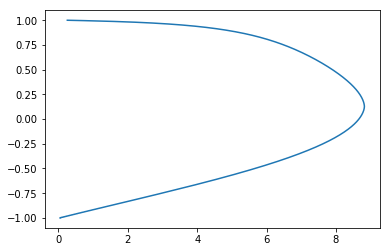

In [11]:
plt.plot(u_star5, y)

## Scipy Root

In [14]:
from scipy.optimize import root

In [17]:
scipy_optimal_res = root(Gf, u0, jac=jacobian, method='lm')

In [18]:
scipy_optimal_res.success

True

In [19]:
u_star = scipy_optimal_res.x

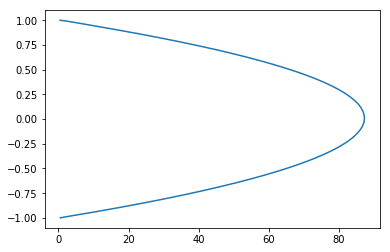

In [20]:
plt.plot(u_star, y)

In [34]:
scipy_optimal_res = root(Gf, u0, method='df-sane')

In [35]:
scipy_optimal_res.success

False

In [36]:
u_star = scipy_optimal_res.x

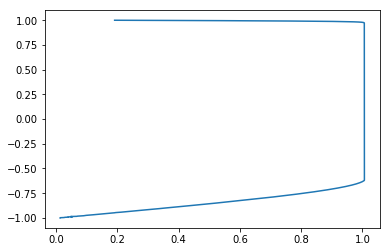

In [37]:
plt.plot(u_star, y)

In [ ]:
scipy_optimal_res = root(Gf, u0, method='broyden1')

/anaconda3/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1000: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)


In [ ]:
scipy_optimal_res.success

## NL Opt

## Scipy Least Squares

In [21]:
from scipy.optimize import least_squares

In [25]:
u_ls = least_squares(Gf, u0)

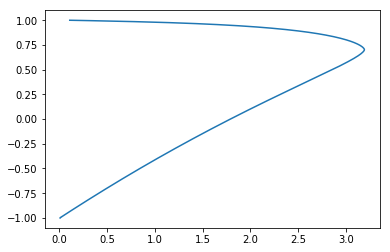

In [26]:
plt.plot(u_ls.x, y)